In [286]:
# importing packages
import pandas as pd
import numpy as np
import time
import qcodes as qc
import pyvisa as visa
import ipywidgets as widgets
# enable to get a more debuggable output:
#visa.log_to_screen()

# importing the instrument driver packages: 
from qcodes.instrument_drivers.yokogawa.GS200 import GS200
from qcodes.instrument_drivers.tektronix.Keithley_2400 import Keithley_2400

# pyvisa-py resource manager
rm = visa.ResourceManager('@py')

print(rm)

Resource Manager of Visa Library at py


In [287]:
# list the resources that the visapy-py backend detects, should look something like:
# `('ASRL/dev/ttyS4::INSTR', 'USB0::2849::57::91LA25023::0::INSTR')`
resources = rm.list_resources()

# intialize the instrument with the following parameters:

# the instrument is initialized and stored as a variable gs, where "gs200" is its name
gs = GS200("gs200", address=resources[0], terminator="\n")

# the instrument is initialized and stored as a variable gs, where "keith" is its name
keith = Keithley_2400("keithley2400", address=resources[1])

libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid descriptor
libgpib: invalid des

Connected to: YOKOGAWA GS210 (serial:91LA25023, firmware:1.05) in 0.18s


KeyError: 'Another instrument has the name: gs200'

In [288]:
station = qc.Station()

In [289]:
station.add_component(gs)
station.add_component(keith)

[gs200_program(GS200Program)] Snapshot: Could not update parameter: trigger
[gs200(GS200)] Snapshot: Could not update parameter: current_range
[gs200(GS200)] Snapshot: Could not update parameter: range
[gs200(GS200)] Snapshot: Could not update parameter: current
[gs200(GS200)] Snapshot: Could not update parameter: output_level


'keithley2400'

In [290]:
keith.print_readable_snapshot()

keithley2400:
	parameter  value
--------------------------------------------------------------------------------
IDN         :	{'vendor': 'KEITHLEY INSTRUMENTS INC.', 'model': '2400', 'seria...
compliancei :	0.000105 
compliancev :	21 
curr        :	9.91e+37 (A)
mode        :	VOLT 
nplci       :	1 
nplcv       :	1 
output      :	True 
rangei      :	0.000105 
rangev      :	21 
resistance  :	2.0193e-38 (Ohm)
sense       :	"VOLT:DC" 
timeout     :	10 (s)
volt        :	2.0011 (V)


In [291]:
gs.print_readable_snapshot()

gs200:
	parameter    value
--------------------------------------------------------------------------------
BNC_in        :	TRIG 
BNC_out       :	TRIG 
IDN           :	{'vendor': 'YOKOGAWA', 'model': 'GS210', 'serial': '91LA25023...
auto_range    :	True 
current       :	0.004 (I)
current_limit :	0.2 (I)
current_range :	0.01 (I)
four_wire     :	off 
guard         :	off 
line_freq     :	60 (Hz)
output        :	on 
output_level  :	0.004 (I)
range         :	0.01 (I)
source_mode   :	VOLT 
system_errors :	-113,"Undefined header, TRIG" 
timeout       :	10 (s)
voltage_limit :	30 (V)


ValueError: max() arg is an empty sequence

In [386]:
import numpy as np
import qcodes as qc
from qcodes.dataset import (
    Measurement,
    experiments,
    initialise_or_create_database_at,
    load_by_run_spec,
    load_or_create_experiment,
)

## Dummy instruments for generating synthetic data
from qcodes.tests.instrument_mocks import (
    DummyInstrument, 
    DummyInstrumentWithMeasurement
)

## Multidimensional scanning module
from qcodes.utils.dataset.doNd import (
    dond, 
    LinSweep
)

## Integrated plotting module
from qcodes.dataset.plotting import plot_dataset

## Using interactive widget
from qcodes.interactive_widget import experiments_widget

In [546]:
gs.reset()
gs.auto_range(True)
gs.source_mode('VOLT')
gs.voltage(0)
gs.output('on')

In [547]:
keith.reset()

In [548]:
# lower the compliance current all the way
#keith.mode('VOLT')
keith._set_mode_and_sense('VOLT')
keith._set_mode_and_sense('CURR')
keith.compliancei(1e-06)
keith.rangev(30)
#keith.sense()
keith.output(1)
# resetting the instrument

In [549]:
keith.mode('VOLT')
keith.sense("CURR:DC")
keith.mode('CURR')
keith.compliancev(3e0)
keith.rangei(0.0000001)
keith.output(1)

In [550]:
initialise_or_create_database_at("~/leds.db")

In [551]:
leds_exp = load_or_create_experiment(
    experiment_name="leds_exp",
    sample_name="green_data"
)

In [552]:
context_meas = Measurement(exp=leds_exp, name='context_example')

In [553]:
# Register the independent parameter...
context_meas.register_parameter(gs.voltage)
# ...then register the dependent parameter
context_meas.register_parameter(keith.curr, setpoints=(gs.voltage,))

In [554]:
# Setting up a doNd measurement
sweep_1 = LinSweep(gs.voltage, 0, 2.5, 100, 0.01)

In [555]:
dond(
    sweep_1,                          # 1st independent parameter
    keith.curr,                     # 1st dependent parameter
    measurement_name="dond_example",  # Set the measurement name
    exp=leds_exp,             # Set the experiment to save data to.
    show_progress=True                # Optional progress bar
)

Starting experimental run with id: 20. Using 'qcodes.dataset.dond'


  0%|          | 0/100 [00:00<?, ?it/s]

(dond_example #20@/root/leds.db
 ------------------------------
 gs200_voltage - numeric
 keithley2400_curr - numeric,
 [None],
 [None])

In [556]:
experiments() 

[leds_exp#green_data#1@/root/leds.db
 -----------------------------------
 1-dond_example-1-gs200_current,keithley2400_volt-50
 2-dond_example-2-gs200_current,keithley2400_volt-500
 3-dond_example-3-gs200_current,keithley2400_volt-100
 4-dond_example-4-gs200_current,keithley2400_volt-100
 5-dond_example-5-gs200_current,keithley2400_volt-100
 6-dond_example-6-gs200_voltage,keithley2400_curr-100
 7-dond_example-7-gs200_voltage,keithley2400_curr-100
 8-dond_example-8-gs200_voltage,keithley2400_curr-100
 9-dond_example-9-gs200_voltage,keithley2400_curr-100
 10-dond_example-10-gs200_voltage,keithley2400_curr-100
 11-dond_example-11-gs200_voltage,keithley2400_curr-100
 12-dond_example-12-gs200_voltage,keithley2400_curr-100
 13-dond_example-13-gs200_voltage,keithley2400_curr-100
 14-dond_example-14-gs200_voltage,keithley2400_curr-100
 15-dond_example-15-gs200_voltage,keithley2400_curr-100
 16-dond_example-16-gs200_voltage,keithley2400_curr-100
 17-dond_example-17-gs200_voltage,keithley2400_cu

In [557]:
leds_exp.data_sets()[-1]

dond_example #20@/root/leds.db
------------------------------
gs200_voltage - numeric
keithley2400_curr - numeric

In [558]:
dataset = leds_exp.data_sets()[-1]

([<AxesSubplot:title={'center':'Run #20, Experiment leds_exp (green_data)'}, xlabel='Voltage (V)', ylabel='Current (pA)'>],
 [None])

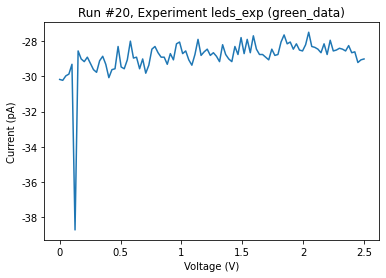

In [559]:
plot_dataset(dataset)

In [515]:
df = dataset.to_pandas_dataframe()
df.reset_index()[:1]

,gs200_voltage,keithley2400_curr
0,0.0,-0.000223


In [516]:
import matplotlib.pyplot as plt

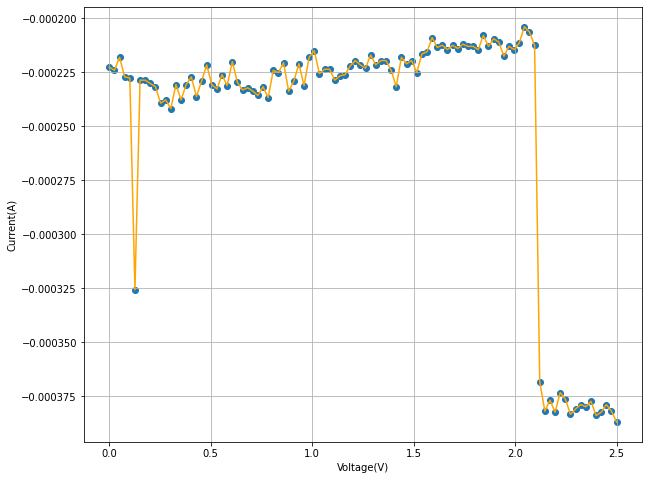

In [517]:
x_axis = df.reset_index().loc[:,"gs200_voltage"]
y_axis = df.reset_index().loc[:,"keithley2400_curr"]

plt.figure(figsize=(10, 8))
ax = plt.axes()
ax.scatter(x=x_axis, y=y_axis)
ax.plot(df, color="orange")

ax.set_ylabel('Current(A)')
ax.set_xlabel('Voltage(V)')

plt.grid()

#plt.xlim([-0.001, 0.001])
plt.show()

In [518]:
gs.reset()

In [519]:
keith.reset()